## Develop Consensus clustering

Put it into clean python file later

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from clustertools.load_data import load_fuzzy_data
from scipy.spatial import distance
from copy import deepcopy
from timeit import default_timer as timer
from datetime import timedelta
import importlib

from clustertools.models import similarity
from clustertools.models import density
from clustertools.models import distance as cl_dist

%matplotlib inline

In [2]:
fuzzy = load_fuzzy_data()
len(fuzzy)

2309

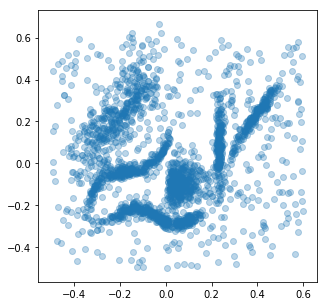

In [3]:
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[:,0], fuzzy[:,1],alpha=.3)

In [4]:
np.random.shuffle(fuzzy)

In [8]:
# Set data

stride = 2
data = fuzzy[::stride]
n = len(data)
k = 10

In [82]:
def noise_to_zero(dbscan_obj):
    '''Returns a copy of the dbscan object with noise-labels set to 0-labels.'''
    dbscan_copy = deepcopy(dbscan_obj)
    for i in range(len(dbscan_copy.cluster_labels)):
        if dbscan_copy.cluster_labels[i] == 'noise':
            dbscan_copy.cluster_labels[i] = 0
    dbscan_copy.cluster_labels = np.array(dbscan_copy.cluster_labels)
    return dbscan_copy

Detected 9 clusters
Finished after 0:00:00.095411
Rate of noise in dataset: 0.314286


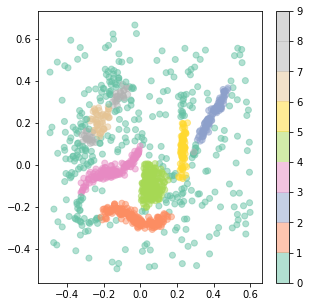

In [83]:
dbscan_obj = density.DBSCAN(data, eps=0.03, minPts=10)
dbscan_obj.fit()
dbscan_obj = noise_to_zero(dbscan_obj)
labels = dbscan_obj.cluster_labels
#print((labels[:] == 'noise'))
#for i in range(len(labels)):
#    if labels[i] == 'noise':
#        labels[i] = 0
#labels[[i for i in range(len(labels)) if labels[i] == 'noise']] = 0
#print(labels)
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', dbscan_obj._n_clusters), alpha=.5)
plt.colorbar()

In [84]:
type(dbscan_obj.cluster_labels)

numpy.ndarray

terminated by break condition
10 iterations until termination.
Finished after 0:00:00.011329
max within-cluster distance to center: 0.437517
mean within-cluster distance to center: 0.089676
sum of within cluster squared errors: 13.534858


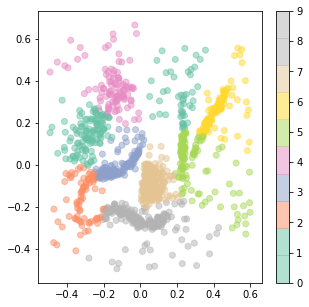

In [10]:
kmeans_obj = cl_dist.KMeans(data, 10)
kmeans_obj.fit()
labels = kmeans_obj.cluster_labels
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

Hierarchical clustering terminated.
Finished after 0:00:05.722896
Stopping cluster number was reached.
Current number of clusters: 10
Current minimum cluster distance: 0.31


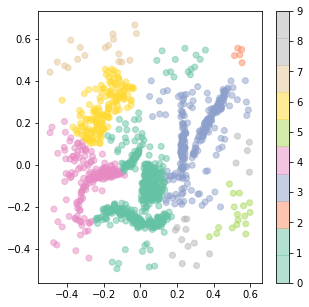

In [11]:
hiercl_obj = similarity.HierarchicalClustering(data, k=10)
hiercl_obj.fit()
labels = hiercl_obj.cluster_labels
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

Constructing gaussian similarity matrix
Computing generalized Laplacian eigenproblem


KMeans initialization on eigenvectors...
terminated by break condition
5 iterations until termination.
Finished after 0:00:00.035794
max within-cluster distance to center: 0.392172
mean within-cluster distance to center: 0.067179
sum of within cluster squared errors: 7.317529
KMeans terminated. 

Finished after 0:00:13.259038


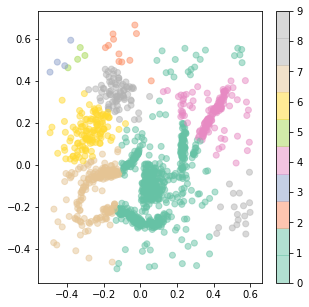

In [12]:
spectral_obj = similarity.SpectralClustering(data, n=10, bandwidth=0.1)
spectral_obj.fit()
labels = spectral_obj.cluster_labels
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

In [13]:
def fit(clusterings, k=5, recluster_what='clusters', how='spectral', **kwargs):
    
    # n: number of data points, that are clustered by different algorithms
    
    # TODO:
    # docstring
    # setze verbose auf verbose
    
    m = len(clusterings)
    assert m > 0, "the list of fitted clustering objects is empty"
    assert any((recluster_what == 'clusters', recluster_what == 'points')), "unknown recluster_what-parameter"
    assert any((how == 'spectral', how == 'hierarchical')), "unknown how-parameter"
    n = len(clusterings[0].cluster_labels)
    assert all(tuple([len(clustering.cluster_labels) == n for clustering in clusterings])), "clusterings did not cluster same amount of points"
    
    # Create array of labels
    labels = np.zeros((n, m)).astype(int)
    num_unique_labels = np.zeros(m).astype(int)
    for j in range(m):
        labels[:, j] = clusterings[j].cluster_labels
        num_unique_labels[j] = len(np.unique(clusterings[j].cluster_labels))
    num_edges = None
    hypergraph = None
    
    # Possibly create hypergraph
    if recluster_what == 'clusters':
        num_edges = np.sum(num_unique_labels).astype(int)
        hypergraph = np.zeros((num_edges, n)).astype(int)
        cluster_sum = 0
        for j in range(m): # for all clusterings
            for l in range(num_unique_labels[j]): # for all cluster labels
                hypergraph[cluster_sum + l, :] = (labels[:, j] == l)
            cluster_sum += num_unique_labels[j]
    
    # Calculate distance matrix of hyperedges or points
    if recluster_what == 'clusters':
        dists = distance.squareform(distance.pdist(hypergraph, 'jaccard'))
    elif recluster_what == 'points':
        dists = distance.squareform(distance.pdist(labels, 'hamming'))
    
    # Recluster
    meta_clustering = None
    if how == 'hierarchical':
        meta_clustering = similarity.HierarchicalClustering(dists, metric=None, k=k)
    if how == 'spectral':
        meta_clustering = similarity.SpectralClustering(dists, similarity_measure=None, n=k)
    meta_clustering.fit()
    meta_labels = meta_clustering.cluster_labels
    
    # Possibly for points
    cluster_labels = np.zeros(n).astype(int)
    if recluster_what == 'points':
        cluster_labels = meta_labels
    if recluster_what == 'clusters':
        point_label_buckets = np.zeros((n, k)).astype(int)
        for edge_ind in range(num_edges):
            point_label_buckets[:, meta_labels[edge_ind]] += hypergraph[edge_ind]
        for i in range(n):
            cluster_labels[i] = np.random.choice(np.flatnonzero(point_label_buckets[i, :] == point_label_buckets[i, :].max()))
        
    return cluster_labels

In [110]:
# Set some parameters

stride = 2
data = fuzzy[::stride]
n = len(data)

#clusterings = [kmeans_obj, kmeans_obj]
#clusterings = [hiercl_obj, hiercl_obj]
clusterings = [hiercl_obj]
#clusterings = [kmeans_obj, dbscan_obj]
#clusterings = [spectral_obj, dbscan_obj, kmeans_obj, hiercl_obj]
recluster_what = 'clusters'
#recluster_what = 'points'
how = 'hierarchical'
#how = 'spectral'
k = 8 # how many clusters to produce

Hierarchical clustering terminated.
Finished after 0:00:00.000371
Stopping cluster number was reached.
Current number of clusters: 8
Current minimum cluster distance: 1.0


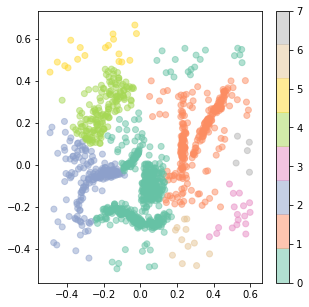

In [111]:
labels = fit(clusterings=clusterings, k=k, recluster_what=recluster_what, how=how) # kwargs-handling noch
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

In [112]:
def nmi(labels_a, labels_b):
    '''
    Calculates the normalized mutual information between two clusterings.
    
    Args:
        labels_a: labels of clustering a, ranging from 0 to k_a - 1, where k_a is the number of labels in that clustering
        labels_b: labels of clustering b, ranging from 0 to k_b - 1, where k_b is the number of labels in that clustering
        
    Output:
        normalized mutual information
    '''
    
    assert len(labels_a) == len(labels_b), "clusterings did not cluster same amount of points"
    
    # Init
    n = len(labels_a)
    k_a = len(np.unique(labels_a))
    k_b = len(np.unique(labels_b))
    entropy_a = 0
    entropy_b = 0
    
    # Compute mutual information estimate and entropy estimate of a (with n cancenlled)
    mutual_information = 0
    for i in range(k_a):
        n_i = sum(labels_a == i)
        if n_i > 0:
            entropy_a += n_i * np.log(n_i / n)
            for j in range(k_b):
                #print(type(labels_b))
                #print(type(labels_b == j))
                n_j = sum(labels_b == j)
                n_ij = sum((labels_a == i) * (labels_b == j))
                if n_ij > 0:
                    mutual_information += n_ij * np.log(n * n_ij / n_i / n_j)
            
    # Compute entropy estimate of b (with n cancenlled)
    for j in range(k_b):
        n_j = sum(labels_b == j)
        if n_j > 0:
            entropy_b += n_j * np.log(n_j / n)
        
    #print("mutual information: {0}".format(mutual_information))
    #print("entropy a: {0}".format(entropy_a))
    #print("entropy b: {0}".format(entropy_b))
    
    return mutual_information / np.sqrt(entropy_a * entropy_b)

In [113]:
def anmi(consensus_labels, clusterings):
    
    m = len(clusterings)
    nmi_sum = 0
    for clustering in clusterings:
        nmi_sum += nmi(consensus_labels, clustering.cluster_labels)
    return nmi_sum / m

### TESTE DIESE FUNKTION IN VERSCHIEDENEN SZENARIEN, Z.B. MIT ZWEI GLEICHEN CLUSTERINGS!

In [114]:
anmi(labels, clusterings)

0.97394924273451589

### wtf warum kommt nicht 1 heraus?? kann es wegen random_choice sein?
Hm, selbst wenn ich nur ein clustering nehme, kommt nicht 1 heraus - aber dann exakt das Gleiche, wie wenn ich zwei gleiche Clusterings nehme!

In [62]:
type(labels)

numpy.ndarray

In [79]:
type(clusterings[1].cluster_labels)

list

In [58]:
sum((clusterings[0].cluster_labels == 1))

19

In [41]:
test_labels_a = np.array([0, 0, 1])
test_labels_b = np.array([0, 1, 1])
nmi(test_labels_a, test_labels_b)

0.27401754212128088

In [35]:
test_labels_a = np.array([1, 1, 2])
test_labels_b = np.array([1, 2, 2])
nmi(test_labels_a, test_labels_b)

mutual information: 0.4054651081081644


C:\Users\Johannes\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: divide by zero encountered in log
C:\Users\Johannes\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: invalid value encountered in multiply
C:\Users\Johannes\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: RuntimeWarning: divide by zero encountered in log
C:\Users\Johannes\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: RuntimeWarning: invalid value encountered in multiply


nan

In [26]:
np.sqrt(2)

1.4142135623730951

In [25]:
np.log(2.71281828)

0.99798805023183201

In [19]:
test_a = np.arange(3)
test_b = np.arange(3, 6)
print(test_a)
print(test_b)
test_a * test_b

[0 1 2]
[3 4 5]


array([ 0,  4, 10])

In [48]:
test = np.arange(3)
test == 1

array([False,  True, False], dtype=bool)

In [49]:
sum(test == 1)

1

In [57]:
np.flatnonzero(np.array([0, 0, 0, 1, 0, 0, 1, 1]))

array([3, 6, 7], dtype=int64)

In [55]:
np.random.choice([0, 2, 5])

0

In [26]:
test = np.array([[0, 0, 0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1, 1, 1]])
test2 = np.array([[0, 0, 0, 0, 1, 1, 1, 1],
                  [0, 0, 0, 1, 0, 0, 1, 1]])
test3 = np.array([[0, 0, 0, 1, 1, 1, 1, 1],
                  [0, 0, 0, 1, 1, 1, 1, 1]])
print(test)
print(test2)
print(test3)
print(distance.squareform(distance.pdist(test, 'jaccard')))
print(distance.squareform(distance.pdist(test2, 'jaccard')))
print(distance.squareform(distance.pdist(test3, 'jaccard')))

[[0 0 0 0 0 1 1 1]
 [0 0 0 1 1 1 1 1]]
[[0 0 0 0 1 1 1 1]
 [0 0 0 1 0 0 1 1]]
[[0 0 0 1 1 1 1 1]
 [0 0 0 1 1 1 1 1]]
[[ 0.   0.4]
 [ 0.4  0. ]]
[[ 0.   0.6]
 [ 0.6  0. ]]
[[ 0.  0.]
 [ 0.  0.]]


In [21]:
test = np.array([[0, 0, 0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1, 1, 1]])
test2 = np.array([[0, 0, 0, 0, 1, 1, 1, 1],
                  [0, 0, 0, 1, 0, 0, 1, 1]])
test3 = np.array([[0, 0, 0, 1, 1, 1, 1, 1],
                  [0, 0, 0, 1, 1, 1, 1, 1]])
test4 = np.array([[0, 2, 2, 1, 1, 1, 1, 1],
                  [0, 2, 3, 1, 1, 1, 1, 1]])
print(test)
print(test2)
print(test3)
print(distance.squareform(distance.pdist(test, 'hamming')))
print(distance.squareform(distance.pdist(test2, 'hamming')))
print(distance.squareform(distance.pdist(test3, 'hamming')))
print(distance.squareform(distance.pdist(test4, 'hamming')))

[[0 0 0 0 0 1 1 1]
 [0 0 0 1 1 1 1 1]]
[[0 0 0 0 1 1 1 1]
 [0 0 0 1 0 0 1 1]]
[[0 0 0 1 1 1 1 1]
 [0 0 0 1 1 1 1 1]]
[[ 0.    0.25]
 [ 0.25  0.  ]]
[[ 0.     0.375]
 [ 0.375  0.   ]]
[[ 0.  0.]
 [ 0.  0.]]
[[ 0.     0.125]
 [ 0.125  0.   ]]


In [22]:
1 - np.arange(4).reshape((2, 2))

array([[ 1,  0],
       [-1, -2]])

In [23]:
np.arange(4)

array([0, 1, 2, 3])